In [1]:
# python libraries
import os
import sys
from pathlib import Path
from typing import (
    List,
    Tuple
)
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# torch
import torch
import torchvision
from torch import nn
from torchvision import (
    transforms,
    datasets
    )
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper

# LeNet

In [2]:
class LeNet(helper.Classifier):
    def __init__(self,lr,num_classes) -> None:
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6,kernel_size=(5,5),padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.LazyConv2d(out_channels=16,kernel_size=5), #! There is no padding done 2nd conv layer
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=120),
            nn.LazyLinear(out_features=84),
            nn.LazyLinear(out_features=self.num_classes)
        )

In [3]:
lenet = LeNet(lr=0.01,num_classes=10)

c:\Users\Lenovo\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
lenet.layer_summary(input_shape=(1,1,28,28))

Conv2d          output shape :(1, 6, 28, 28)
Sigmoid         output shape :(1, 6, 28, 28)
AvgPool2d       output shape :(1, 6, 14, 14)
Conv2d          output shape :(1, 16, 10, 10)
Sigmoid         output shape :(1, 16, 10, 10)
AvgPool2d       output shape :(1, 16, 5, 5)
Flatten         output shape :(1, 400)
Linear          output shape :(1, 120)
Linear          output shape :(1, 84)
Linear          output shape :(1, 10)


In [5]:
def init_cnn(module):
    if isinstance(module,(nn.Linear,nn.Conv2d)):
        nn.init.xavier_uniform_(module.weight)

# Data

In [6]:
class FashionMNIST(helper.DataModule):
    def __init__(self, batch_size: int = 64, resize=(28, 28)) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.resize = resize

        transform = transforms.Compose(
            [transforms.Resize(resize), transforms.ToTensor()]
        )

        self.train = datasets.FashionMNIST(
            root=self.root, train=True, transform=transform,download=True
        )
        self.val = datasets.FashionMNIST(
            root=self.root, train=False, transform=transform,download=True
        )
        self.classes = self.train.classes
        self.class_to_idx = self.train.class_to_idx

    def text_labels(self, indices: List):
        return [self.classes[a] for a in indices]

    def get_dataloader(self, train: bool):
        data = self.train if train else self.val
        return DataLoader(
            dataset=data,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=train,
        )
    
    def visualize(self,batch:Tuple,num_rows=1,num_cols=8):
        X,y = batch
        labels = self.text_labels(y)
        helper.show_images(X.squeeze(1),num_rows=num_rows,num_cols=num_cols,titles=labels)

# Training the model

In [7]:
data = FashionMNIST(batch_size=128)
model = LeNet(lr=0.1,num_classes=len(data.classes))
model.apply_init([next(iter(data.get_dataloader(True)))[0]],init_cnn)


Training the model in cpu


  0%|          | 0/3 [00:00<?, ?it/s]

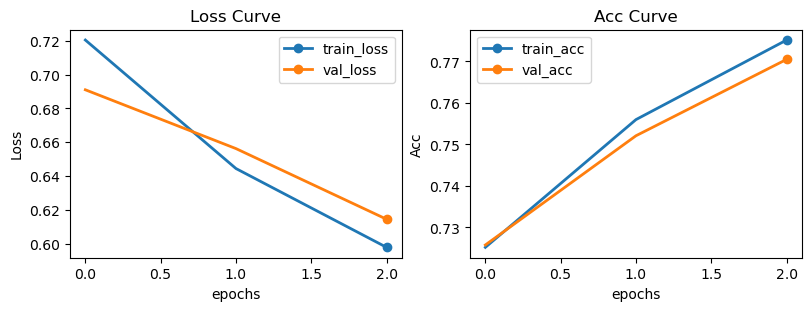

In [9]:
trainer = helper.Trainer(max_epochs=3)
trainer.fit(model,data)